# Source Code Analysis

## Initialization

In [1]:
import os
import sys

def add_path(path):
    if path not in sys.path:
        sys.path.insert(0, path)
        sys.path.append(path)
# add_path('/home/jjian03/anaconda3/lib/python3.7/site-packages')
add_path(f'{os.path.abspath(os.path.join(".."))}')


### Load Data

In [2]:
import time, datetime, numpy as np, pandas as pd

seed = 77
np.random.seed(seed)

data_file = '../untrunc_data_cleaned_url.csv'

raw_data = pd.read_table(data_file, sep=',', index_col=0)
raw_data = raw_data.dropna()

raw_data.info()

print(f'raw_data: {raw_data.shape}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58871 entries, 0 to 58909
Data columns (total 42 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   protocol_type                           58871 non-null  float64
 1   has_www                                 58871 non-null  float64
 2   has_iframe                              58871 non-null  float64
 3   int                                     58871 non-null  float64
 4   org                                     58871 non-null  float64
 5   gov                                     58871 non-null  float64
 6   in                                      58871 non-null  float64
 7   eu                                      58871 non-null  float64
 8   cn                                      58871 non-null  float64
 9   kr                                      58871 non-null  float64
 10  url_depth                               58871 non-null  fl

### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


x = raw_data
y = raw_data.label
y_scaler = preprocessing.StandardScaler()
y = y_scaler.fit_transform(y.values.reshape(-1, 1))
y = pd.DataFrame(y).iloc[:,0]


X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    x, y, test_size = 0.33, random_state=seed)

X_train = X_train_raw.drop(['label', 'first_appear', 'url'], axis=1)
X_test = X_test_raw.drop(['label', 'first_appear', 'url'], axis=1)


In [4]:
import gc
import multiprocessing

import warnings
warnings.filterwarnings("ignore")


cpu_cnt = multiprocessing.cpu_count()
allocated_cpu = cpu_cnt
print(f"Allocated {allocated_cpu} CPUs")
gc.collect()

Allocated 16 CPUs


20

#### L-BFGS-B

In [5]:
from concurrent.futures.thread import ThreadPoolExecutor

from sklearn.model_selection import GridSearchCV

from Toolbox import ParameterGenerator
from tobit import *


start_time = time.time()

p_censor_left = -math.inf
p_censor_right = max(y)


param_tr = {
    'C': [round(i, 2) for i in np.arange(0, 70, 0.4).tolist()],
    'alpha': [.55, 1],
}

tr = TobitRegressor(
    p_censor_left=p_censor_left,
    p_censor_right=p_censor_right,
    C=49.8,
    alpha=1,
    verbose=True,
)

tr.fit(X_train, y_train)


      fun: 17594.505647335143
 hess_inv: <41x41 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -0.40542494, -74.39674219,   1.8454924 ,  -4.85953141,
        12.07823688,  10.38446239,   6.93857997,  62.23045814,
       -58.03550329,  61.29684277,  48.83918123,  -1.57102349,
         3.60715368,  -5.85181782,   2.31548927,  -1.18523422,
        -4.19210476,  -0.47255536,  10.48051319,  10.13829471,
        15.28044783,   8.49887641,  -3.4960376 ,  -7.74439822,
         8.07323143,  59.29110829, -63.65094875, -51.90170804,
        32.63743588,  -0.81135998,  29.69924304,  -4.81545218,
        -6.67992391,  -2.67018376,   7.98128273,  -0.94792222,
        -4.45162598,  10.39501414, -46.25096843,  -0.22427238,
         0.38757728])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 210
      nit: 142
   status: 0
  success: True
        x: array([ 6.98786232e+00, -1.41483000e-06, -5.81450280e-01, -6.10470413e-01,
        2.25462234e-06,  1.10335016e-01,  

TobitRegressor(C=49.8, alpha=1, p_censor_left=-inf,
               p_censor_right=0.2614519501713601, verbose=True)

### Predict

In [6]:
pred = tr.predict(X_test)
pred


44568    4.674123
34461    8.572587
9716     9.004447
39796    5.249486
26012    4.518504
           ...   
47103    3.813929
13996    3.470684
9533     2.924835
56769    4.594634
54035    9.362539
Length: 19428, dtype: float64

In [7]:
y_pred = y_scaler.inverse_transform(pred)
y_pred = y_pred + 1990

In [8]:
life_span = pd.Series(y_pred - X_test_raw.first_appear)
life_span.name = 'life_span'
urls = pd.merge(life_span, raw_data.url, how='inner',
         left_index=True, right_index=True)

raw_data = raw_data.drop('url', axis=1)
urls = pd.merge(urls, raw_data, how='inner',
         left_index=True, right_index=True)

urls.life_span

44568    13.643906
34461    22.280537
9716     24.126502
39796    12.770973
26012    11.339065
           ...    
47103     8.958886
13996     9.286510
9533      8.217255
56769    13.488194
54035    24.827962
Name: life_span, Length: 19428, dtype: float64

In [9]:
urls.loc[:, 'actual_life_span'] = urls.label + 1990 - urls.first_appear

urls = urls[urls.life_span >= 0]
urls = urls[urls.actual_life_span >= 0]

In [10]:
from scipy import stats


urls.loc[:, 'is_gov'] = urls.gov == 1
urls_gov = urls[urls.gov == 1]
urls_others = urls[urls.gov != 1]


In [11]:
stats.ttest_ind(urls_gov.life_span, urls_others.life_span, equal_var = False)


Ttest_indResult(statistic=-6.627501469800641, pvalue=3.939722360922394e-11)

In [12]:
stats.ttest_ind(urls_gov.actual_life_span, urls_others.actual_life_span, equal_var = False)


Ttest_indResult(statistic=-0.38615839686623293, pvalue=0.6994034859330576)

Text(0.5, 1.0, 'The predicted life span distribution of the websites')

<Figure size 432x288 with 0 Axes>

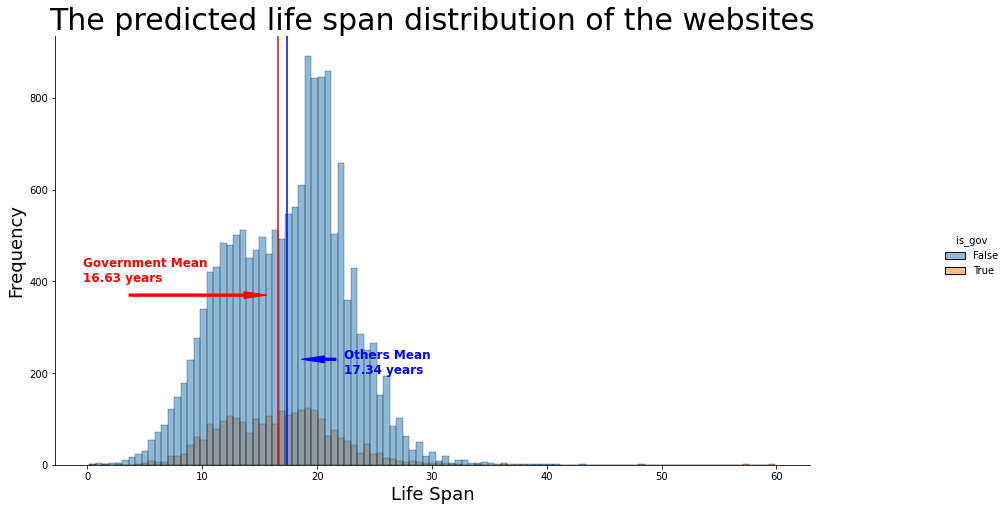

In [13]:
import matplotlib.pyplot as plt, matplotlib.style as style, seaborn as sns
from scipy.stats import norm
%matplotlib inline


plt.clf()
# style.use('fivethirtyeight')
fig = sns.displot(urls, x="life_span", hue="is_gov")

fig.fig.set_size_inches(15,7)

plt.arrow(urls_gov.life_span.mean()-13, 370, 10, 0, width=5, head_length=2, color='red')
plt.axvline(urls_gov.life_span.mean(), 0, 10, c='red')
plt.text(urls_gov.life_span.mean()-17, 400, f'Government Mean\n{round(urls_gov.life_span.mean(), 2)} years', c='red', size='large', weight='bold')

plt.arrow(urls_gov.life_span.mean()+5, 230, -1, 0, width=5, head_length=2, color='blue')
plt.axvline(urls_others.life_span.mean(), 0, 10, c='blue')
plt.text(urls_others.life_span.mean()+5, 200, f'Others Mean\n{round(urls_others.life_span.mean(), 2)} years', c='blue', size='large', weight='bold')

plt.xlabel('Life Span', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('The predicted life span distribution of the websites', fontsize=30)


Text(0.5, 1.0, 'The actual life span distribution of the websites')

<Figure size 432x288 with 0 Axes>

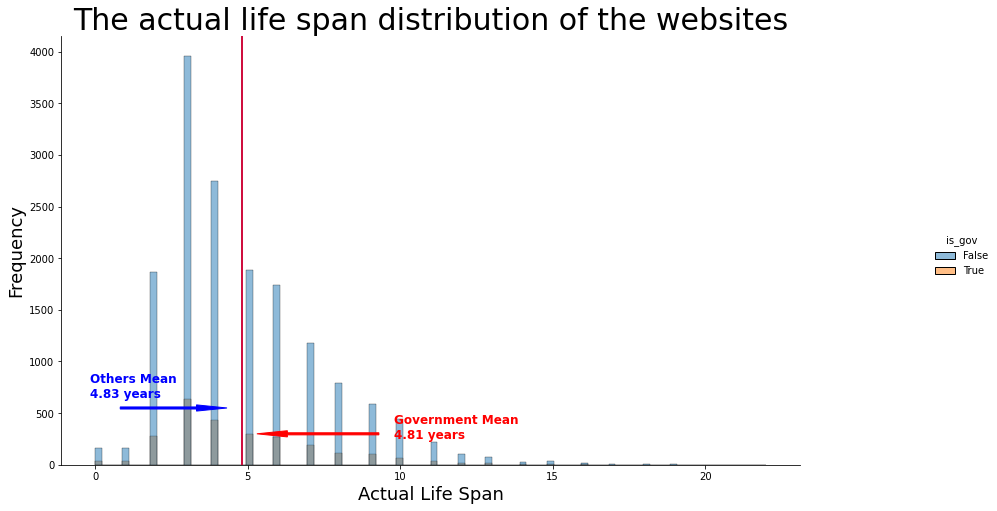

In [14]:
plt.clf()
# style.use('fivethirtyeight')
fig = sns.displot(urls, x="actual_life_span", hue="is_gov")

fig.fig.set_size_inches(15,7)

plt.arrow(urls_others.actual_life_span.mean()-4, 550, 2.5, 0, width=20, head_length=1, color='blue')
plt.axvline(urls_others.actual_life_span.mean(), 0, 10, c='blue')
plt.text(urls_others.actual_life_span.mean()-5, 650, f'Others Mean\n{round(urls_others.actual_life_span.mean(), 2)} years', c='blue', size='large', weight='bold')

plt.arrow(urls_gov.actual_life_span.mean()+4.5, 300, -3, 0, width=20, head_length=1, color='red')
plt.axvline(urls_gov.actual_life_span.mean(), 0, 10, c='red')
plt.text(urls_gov.actual_life_span.mean()+5, 250, f'Government Mean\n{round(urls_gov.actual_life_span.mean(), 2)} years', c='red', size='large', weight='bold')

plt.xlabel('Actual Life Span', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('The actual life span distribution of the websites', fontsize=30)
